# Pneumonia classification from X-ray images
In this notebook we will train a convolutional neural network (CNN) to classify X-ray images as being from patients with or without pneumonia. The dataset (available on [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)) from Mendeley Data contains a total of 5863 X-ray images which are split into two categories; normal or pneumonia. Here we will fine-tune a pretrained ResNet-18 model.

ADD FIGURE OF EXAMPLE X-RAYS

The aim of this notebook is to develop an end-to-end workflow to allow models to be trained and deployed on AWS SageMaker. We will try to get a reasonable model, but achieving the very best results is not the main objective.

In this case, I run the notebook on my local machine on VS Code. To run on a SageMaker notebook instance (or in SageMaker Studio) you will need to make some small changes, which I will try to highlight throughout the notebook.

## Running the notebook
The notebook can either be run directly on SageMaker (through a SageMaker notebook instance or SageMaker Studio) or on your local machine. I prefer to run the notebook locally for a number of reasons:
- First, I often face issues with SageMaker notebooks when I download and extract a dataset (like we will do in this notebook). Often the notebook will become very slow and I've not been able to determine the cause.
- Secondly (and perhaps more importantly), I don't need to worry about accidentally leaving an instance running on SageMaker and incurring extra costs. 

Of course, there are a few downsides to running the notebook locally. For instance, we need to setup and manage our own Python environment, but this is not too difficult using tools such as [Miniconda](https://docs.conda.io/en/latest/miniconda.html).

**Note:** While I run the notebook locally, the model training jobs and hyperparameter tuning are sent to be run on SageMaker managed instances.

### Run from local machine in VSCode
Here I am running the notebook through VS Code on my local machine using Ubuntu and my own Python virtual enviornment. I suggest to run on a Linux operating system as I faced issues when trying to run on Windows.

#### 1. Setup Python virtual environment
Make sure you have created a Python virtual environment using the `conda.yml` file provided in the repository.

```
conda env create -f environment.yml
```

#### 2. Configure AWS credentials
To be able to connect to your AWS account via VSCode, you first need to retrieve and store your credentials. To do this you should:

1. Install the AWS toolkit for Visual Studio Code (see [here](https://docs.aws.amazon.com/toolkit-for-vscode/latest/userguide/setup-toolkit.html))
2. Setup AWS credentials file (see [here](https://docs.aws.amazon.com/toolkit-for-vscode/latest/userguide/setup-credentials.html#setup-credentials-set-access-keys))

You should make sure that your credentials are associated with the corect AWS region. You can also refer to [this](https://towardsdatascience.com/setting-up-amazon-sagemaker-environment-on-your-local-machine-7329e0178adc) article for a useful walkthrough of running SageMaker locally.


### Running in SageMaker studio/notebook instance
You can try to run the notebook directly in a SageMaker notebook instance or SageMaker studio. You simply need to clone this repository and make sure you select one of the `Python 3 (PyTorch 1.8)` kernels.

I'll try to point out through the notebook where you may need to do things differently to how I ran it on my local machine. For instance, you will need to uncomment and run the cell below to install some additional packages that are not included in the SageMaker PyTorch image.



In [1]:
## If running in SageMaker notebook or Studio, you should uncomment this cell and run to install the additional packages required. 
# !pip install smdebug
# !pip install kaggle
# !pip install wandb
# !pip install Pillow
# !pip install wandb

## Import packages

In [2]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import CollectionConfig, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import boto3
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import wandb
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from zipfile import ZipFile
import json
from random import sample
import shutil
import os
import IPython

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision import transforms

[2022-04-02 00:26:46.782 DESKTOP-T8O836C:10544 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


/home/robsmith155/miniconda3/envs/aws-nd-project3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global variables and settings

Please update the variables below for your own S3 bucket and directory structure.

In [3]:
S3_BUCKET_NAME = 'robsmith155-courses' # Set this to your AWS S3 bucket
LOCAL_HOME_DIR = '/home/robsmith155' # Home directory on your local machine. This will be used to store tokens created by Kaggle.
LOCAL_DATA_DIR = './chest_xray' # Local path where data is downloaded
S3_DATA_PREFIX = 'udacity-aws-nd/course3/project/data' # Directory to store data on S3

### SageMaker role (running on local enviornment)

Before running this you need to make sure that you have created a SageMaker execution role. See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html#sagemaker-roles-create-execution-role) for guidance on creating a SageMaker execution role in the IAM console.

Note that the role needs the following policies attached:
- AWSS3FullAccess
- AWSSageMakerFullAccess

If running from SageMaker studio, we can use the `get_execution_role` function from the SageMaker SDK to get the role ARN (since a role is attached to the notebook instance). 

This is not possible if running locally, so we have two options. Either you can go to the IAM console in AWS and copy the ARN of the SageMaker execution role you want to use. The alternative is to use the `boto3` SDK to retrieve the information for the specified role name as shown below. You will need to replace this with youw own SageMaker execution role.

In [103]:
iam_client = boto3.client('iam')
SAGEMAKER_ROLE_ARN = iam_client.get_role(RoleName='AmazonSageMaker-ExecutionRole-20220215T183023')['Role']['Arn']

In [104]:
print(SAGEMAKER_ROLE_ARN)

arn:aws:iam::377574710449:role/service-role/AmazonSageMaker-ExecutionRole-20220215T183023


### SageMaker role (running on SageMaker notebook instance or Studio)
If running on a SageMaker notebook instance or Studio, by default you have already creates a SageMaker execution role. In this case, we can get the ARN of the running role using the `get_execution_role()` method. If running this way you can uncomment and run the cell below.

In [ ]:
# sess = sagemaker.Session()
# SAGEMAKER_ROLE_ARN = sagemaker.get_execution_role()

## Configure Weights and Biases (optional)
I've made the code so that the training jobs can be tracked in Weights and Biases. You can skip this section if you don't want to track with W&B, but make sure that the `wandb_tracking` parameter is set to 'false' in the training job hyperparameters (note this should be a string, not Boolean).

If you would like to use this, you will need to do the following:

1. Make sure you've setup a Weights & Biases account (see [here](https://wandb.ai/site))
2. Install the `wandb` Python package (if you used the enviornment file in this repo you should already have this)


In [ ]:
#wandb.login()

Create `secrets.env` file with your credentials.

In [ ]:
# !mkdir -p source_dir
# wandb.sagemaker_auth(path="source_dir")


An entry has been added to the `.gitignore` file so that the key will not be uploaded to your GitHub repo.

## Dataset
In this project we will work with the chest X-ray dataset for indentifying pneumonia which is available on [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

Our first job is to download the dataset and upload the extracted images to an S3 bucket so that they can be accessed by SageMaker.

### Download dataset
If running for the first time, you need to download the dataset from Kaggle. You can either go to the [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) webpage and download it manually, or you can configure the Kaggle CLI to download it.

For the latter, you will need to login to your Kaggle account and create a new API token (if you don't already have one):

1. Go to your Kaggle account and click on your profile picture (top right corner). Select `Account`.

<p align="center">
    <img src="./imgs/create-kaggle-api1.png", width="800">
</p>
<p align="center">
    <em>Go to your Kaggle Account page.</em>
</p>


2. Create new API token

Now scroll down to the API section and click on **Create New API Token**. 

<p align="center">
    <img src="./imgs/create-kaggle-api2.png", width="800">
</p>
<p align="center">
    <em>Create new Kaggle API key.</em>
</p>

This will download a `kaggle.json` containing your username and key. Either you can put this in the correct location manually (`~/.kaggle/kaggle.json`) or you can copy the key from the file and uncomment the cells below to do this. Note that you need to update the `kaggle_username` and `kaggle_key` fields to your own account information.

**Once the file is created, be sure to delete your Kaggle API key from the `kaggle_key` field below (if you use this method) so you don't accidentally publish it on GitHub.**

In [7]:
# # create the .kaggle directory and an empty kaggle.json file
# !mkdir -p {LOCAL_HOME_DIR}/.kaggle
# !touch {LOCAL_HOME_DIR}/.kaggle/kaggle.json
# !chmod 600 {LOCAL_HOME_DIR}/.kaggle/kaggle.json

In [9]:
# # Fill in your user name and key from creating the kaggle account and API token file

# kaggle_username = "robsmith155"
# kaggle_key = "INSERT KEY HERE"

# # Save API token the kaggle.json file
# with open(f"{LOCAL_HOME_DIR}/.kaggle/kaggle.json", "w") as f:
#     f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

Now we can download the dataset using the Kaggle CLI:

In [10]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia;

100%|█████████████████████████████████████▉| 2.29G/2.29G [03:24<00:00, 13.6MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [03:24<00:00, 12.0MB/s]


This downloads a zipped file. We can extract the contents using `ZipFile`:

In [3]:
# with ZipFile('chest-xray-pneumonia.zip', 'r') as zipObj:
#    # Extract all the contents of zip file
#    zipObj.extractall();

### Check number of files extracted

In [61]:
# num_train_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/train/NORMAL'))
# num_train_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/train/PNEUMONIA'))
# num_training_samples = num_train_samples_pneumonia + num_train_samples_normal

# num_val_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/val/NORMAL'))
# num_val_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/val/PNEUMONIA'))
# num_val_samples = num_val_samples_pneumonia + num_val_samples_normal

# num_test_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/test/NORMAL'))
# num_test_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/test/PNEUMONIA'))
# num_test_samples = num_test_samples_pneumonia + num_test_samples_normal

# print(f'Total training samples: {num_training_samples}')
# print(f'Total validation samples: {num_val_samples}')
# print(f'Total test samples: {num_test_samples}')

Total training samples: 5216
Total validation samples: 16
Total test samples: 624


As we can see, the validation set is tiny. I have no idea why they split the data in this way, but 16 samples is not really sufficient for us to evaluate the model performance.

### Move some samples from test to validation dataset

We could move some of the training samples to the validation set, but we already have a very small dataset to train with (5216 X-rays). Instead I will move some of the test images to the validation dataset so that they have an equal number of samples. To do this I'll randomly sample from the test dataset, taking the same proportion of images from the normal and pneumonia folders. We'll look into issues of class imbalance later. I'm making an assumption here that the validation and test datasets belong to the same distribution as the training data.

In [60]:
# num_val_test_images = num_test_samples_normal + num_test_samples_pneumonia + num_val_samples_normal + num_val_samples_pneumonia
# print(f'Total validation + test images: {num_val_test_images}')

Total validation + test images: 640


We'll aim here to have approximately the same number of images in the validation and test datasets. We have a total of 640 images in these two sets, so we want to have around 320 in each.

In [62]:
# num_images_to_move = 320 - num_val_samples
# proportion_pneumonia_test = num_test_samples_pneumonia / num_test_samples
# proportion_normal_test = 1 - proportion_pneumonia_test
# num_pneumonia_to_move = round(num_images_to_move * proportion_pneumonia_test)
# num_normal_to_move = round(num_images_to_move * proportion_normal_test)

# print(f'Number of pneumonia images to move: {num_pneumonia_to_move}')
# print(f'Number of normal images to move: {num_normal_to_move}')

Number of pneumonia images to move: 190
Number of normal images to move: 114


Now we will randomly select these images from the test folders and move them to the validation directory.

In [65]:
def move_images(from_dir, to_dir, num_images):
    img_files = os.listdir(from_dir)
    img_files_move = sample(img_files, num_images)
    for file in img_files_move:
        from_path = os.path.join(from_dir, file)
        to_path = os.path.join(to_dir, file)
        shutil.move(from_path, to_path)

In [66]:
# normal_test_dir = f'{LOCAL_DATA_DIR}/test/NORMAL'
# normal_val_dir = f'{LOCAL_DATA_DIR}/val/NORMAL'
# move_images(normal_test_dir, normal_val_dir, num_normal_to_move)

In [67]:
# pneumonia_test_dir = f'{LOCAL_DATA_DIR}/test/PNEUMONIA'
# pneumonia_val_dir = f'{LOCAL_DATA_DIR}/val/PNEUMONIA'
# move_images(pneumonia_test_dir, pneumonia_val_dir, num_pneumonia_to_move)

Let's check that we have the expected number of validation and test images:

In [68]:
# num_val_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/val/NORMAL'))
# num_val_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/val/PNEUMONIA'))
# num_val_samples = num_val_samples_pneumonia + num_val_samples_normal

# num_test_samples_normal = len(os.listdir(f'{LOCAL_DATA_DIR}/test/NORMAL'))
# num_test_samples_pneumonia = len(os.listdir(f'{LOCAL_DATA_DIR}/test/PNEUMONIA'))
# num_test_samples = num_test_samples_pneumonia + num_test_samples_normal

# print(f'Total training samples: {num_training_samples}')
# print(f'Total validation samples: {num_val_samples}')
# print(f'Total test samples: {num_test_samples}')

Total training samples: 5216
Total validation samples: 320
Total test samples: 320


### Upload to S3 bucket
To train the model on AWS SageMaker, the data needs to be in an S3 bucket. We can do this by creating a session with the `sagemaker` SDK and then using the `upload_data()` method.

In [5]:
sagemaker_session = sagemaker.Session(default_bucket=S3_BUCKET_NAME)

Let's check that we have the correct bucket and region for the session:

In [6]:
sagemaker_session.default_bucket(), sagemaker_session._region_name

('robsmith155-courses', 'us-east-1')

In [71]:
# inputs = sagemaker_session.upload_data(path=LOCAL_DATA_DIR, bucket=S3_BUCKET_NAME, key_prefix=S3_DATA_PREFIX)
# print(f"Data has been uploaded to: {inputs}")

Data has been uploaded to: s3://robsmith155-courses/udacity-aws-nd/course3/project/data


### Check data in bucket

We can use the Boto3 SDK to connect to S3 and check that the data has been uploaded. 

In [72]:
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=S3_BUCKET_NAME, Prefix=S3_DATA_PREFIX)['Contents']

In [73]:
contents[0]

{'Key': 'udacity-aws-nd/course3/project/data/test/NORMAL/IM-0001-0001.jpeg',
 'LastModified': datetime.datetime(2022, 3, 25, 11, 51, 53, tzinfo=tzutc()),
 'ETag': '"6535e4c9b865af758eb077d28864c334"',
 'Size': 252680,
 'StorageClass': 'STANDARD',
 'Owner': {'DisplayName': 'robsmith155',
  'ID': 'b9edd0ce8767426bd11f3546255f6f1e61fc62f411bbd6bcdf3cdd0d99570ae3'}}

In [74]:
len(contents)

1000

Note that by default the `list_objects` method returns a maximum of 1000 objects. Below I print the path of the first five objects retrieved.

In [75]:
for i in range(5):
    print(contents[i]['Key'])

udacity-aws-nd/course3/project/data/test/NORMAL/IM-0001-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0006-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0013-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0016-0001.jpeg
udacity-aws-nd/course3/project/data/test/NORMAL/IM-0029-0001.jpeg


So it looks like the data has been uploaded correctly.

## EDA
Now let's take a look at the data to identify any issues and help us to understand the pre-processing workflow that is required before training a model.

### Class distribution
First let's look at the distribution of the images to determine whether we have a balanced dataset or not.

Text(0.5, 1.0, 'Proportion of normal-pneumonia images for each dataset')

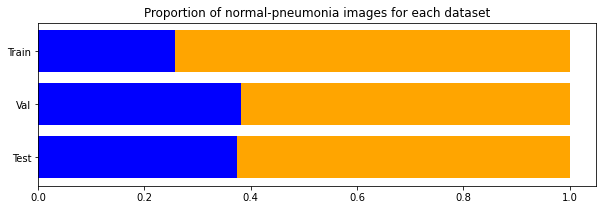

In [92]:
fig = plt.figure(figsize=(10,3))

plt.barh('Test', width = num_test_samples_normal / num_test_samples, color='b')
plt.barh('Test', width = num_test_samples_pneumonia / num_test_samples, color='orange', left = num_test_samples_normal / num_test_samples)
plt.barh('Val', num_val_samples_normal / num_val_samples, color='b')
plt.barh('Val', num_val_samples_pneumonia / num_val_samples, color='orange', left=num_val_samples_normal / num_val_samples)
plt.barh('Train',num_train_samples_normal / num_training_samples, color='b')
plt.barh('Train', num_train_samples_pneumonia / num_training_samples, color='orange', left=num_train_samples_normal / num_training_samples)
plt.title('Proportion of normal-pneumonia images for each dataset')

So we can see that the dataset is imbalanced, particularly for the training dataset. Here we have around three pneumonia examples for every normal x-ray. If we don't account for this then a model may be biased towards the dominant class (which in this case is x-rays with pneumonia). The training and validation datasets are not quite as bad, with around two pneumonia X-rays for every normal sample.

### Plot random sample of images

The function below will plot nine random X-ray images from the directory that is passed to the function. Along with the image it will also print the image dimensions to help us understand what we are working with.

In [85]:
def plot_sample_xrays(data_dir: str):
    img_names =  os.listdir(data_dir)
    files = sample(img_names, 9)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.suptitle('Example X-ray images')
    for file, ax in zip(files, axes.ravel()):
        img_path = os.path.join(data_dir, file)
        img = np.array(Image.open(img_path))
        img_height, img_width = img.shape
        
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Image size (w x h): {img_width} x {img_height} pixels')

#### Sample of normal X-rays

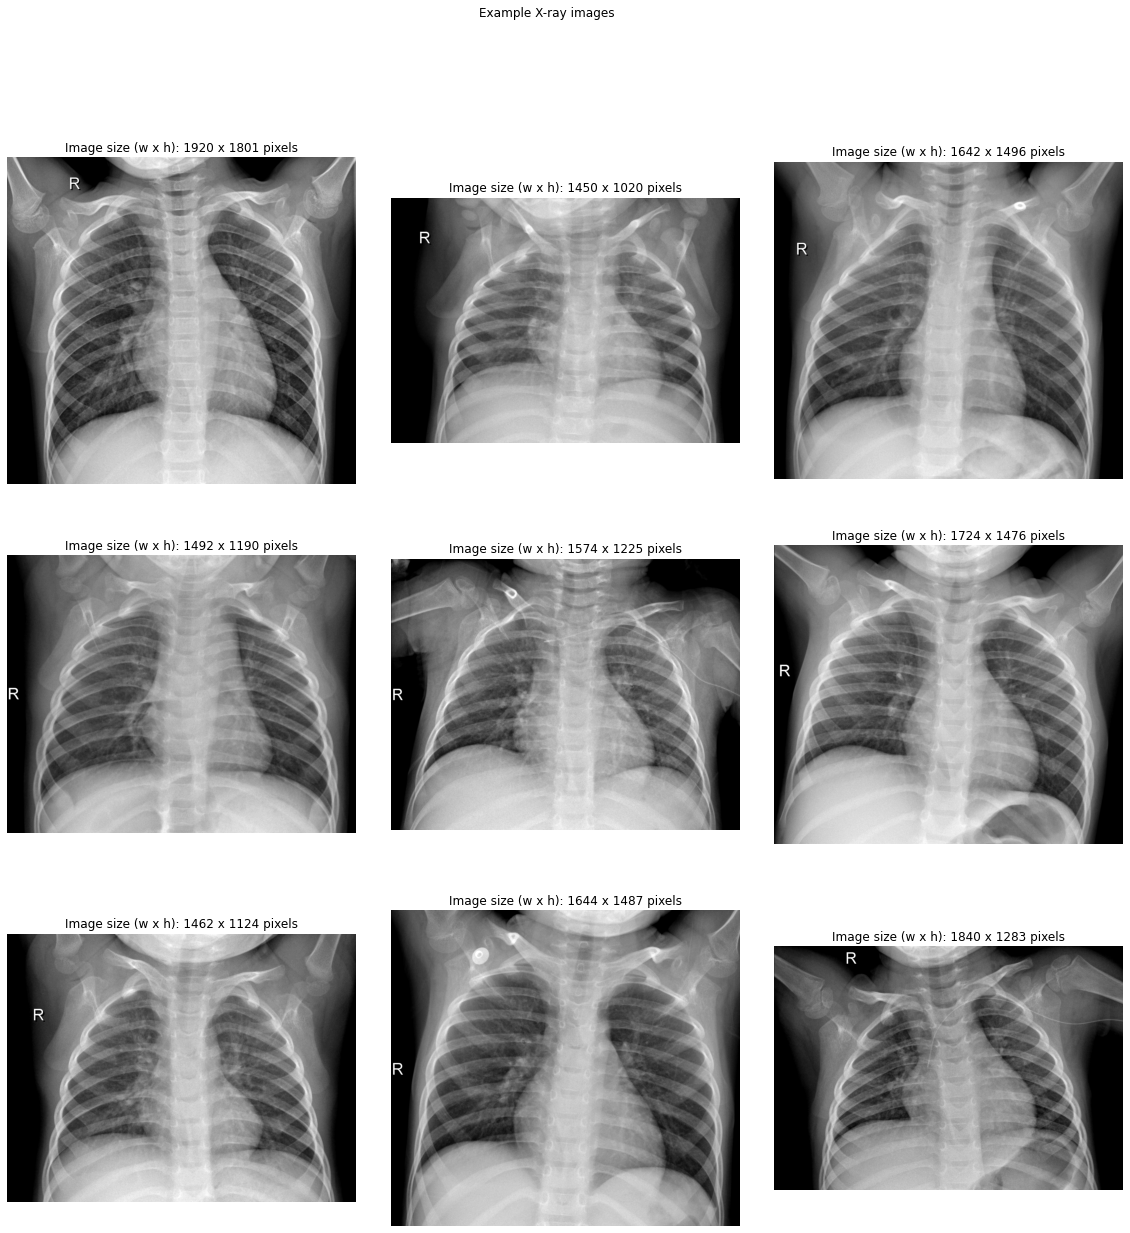

In [86]:
plot_sample_xrays(f'{LOCAL_DATA_DIR}/train/NORMAL')

#### Sample of X-rays with pneumonia

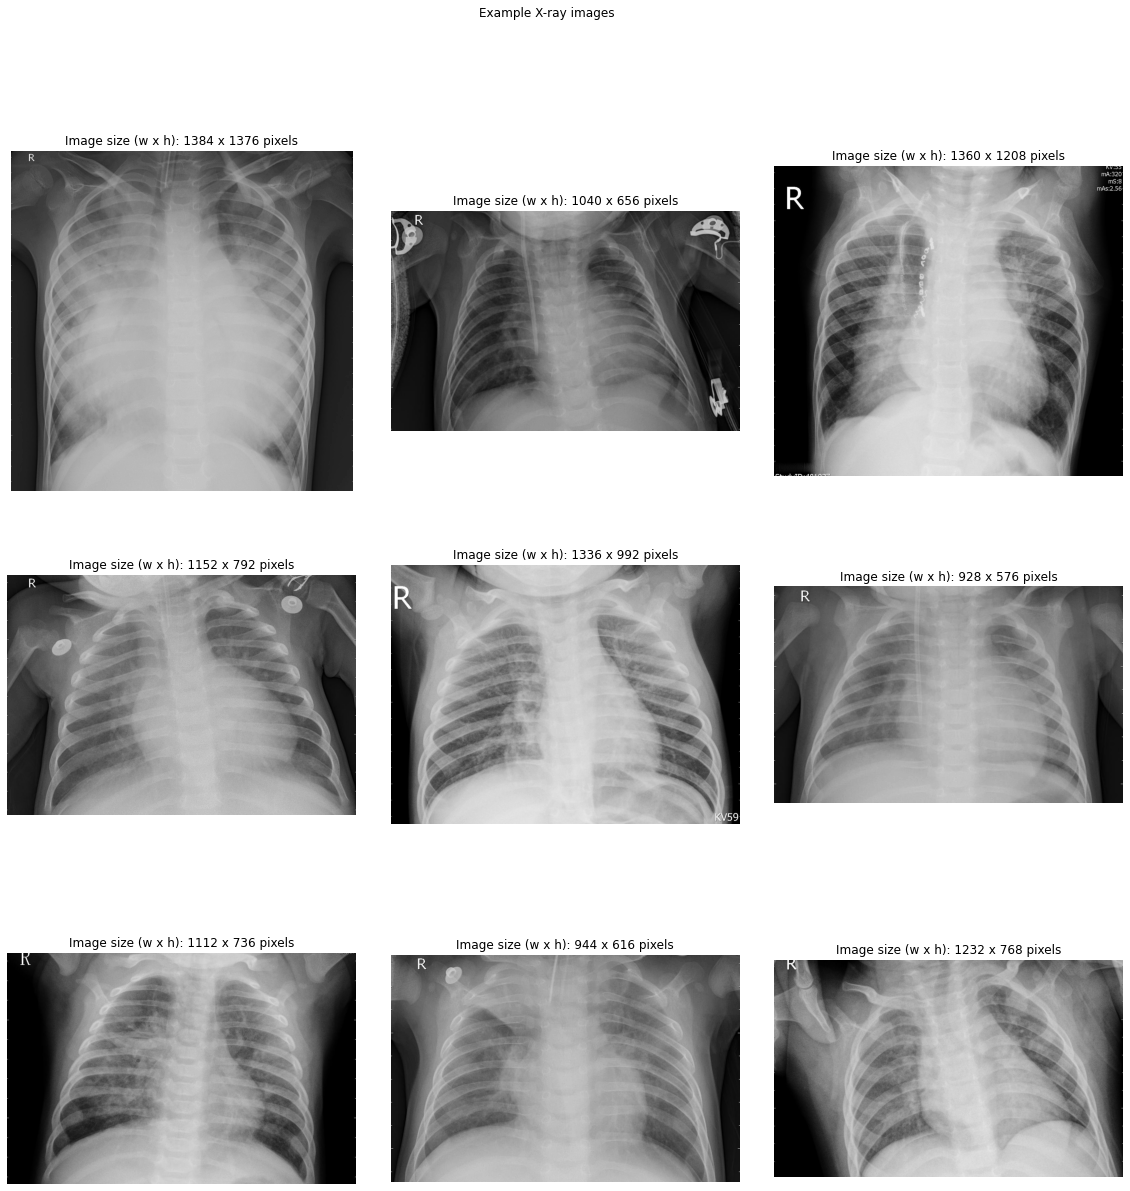

In [88]:
plot_sample_xrays(f'{LOCAL_DATA_DIR}/train/PNEUMONIA')

### Observations
We can see that in general, compared to the normal x-rays, those classified as pneumonia are less clear (increased opacity). Apparently a radiologist will look for white spots in the lungs (known as infiltrates) that are indicative of infection [(source)](https://www.radiologyinfo.org/en/info/pneumonia). Another useful source for radiology interpretation can be found [here](https://radiologyassistant.nl/chest/chest-x-ray/lung-disease).

A number of issues that need to be addressed during pre-processing are identified from these example images:
- The images are large, with many dimensions being more than 1000 pixels in size. For convolutional neural networks we typically use images of 256 x 256 pixels or less.
- The images are different sizes
- The images are not square, so when we resize we'll have to take a crop of the image
- We have a small training dataset, so we should use data augmentation to increase the data variation
- Imbalanced dataset - we have more X-rays showing pneumonia than normal X-rays
- Images are single channel (i.e. grayscale) while models pretrained on ImageNet expect three channel (i.e. RBG) input

We will need to take care of some of these issues when building the preprocessing pipeline.

## Develop PyTorch DataLoader

In PyTorch, we need to use a Dataset and DataLoader to pass data to the model. In this section we will develop these to try and account for some of the issues identified in the previous section and make sure the outputs are as expected before going on to train a model.

### Develop image augmentation workflow
For the training data, we can use image augmentation to allow the network to see more variations than are present in X-ray images we have been provided with. This can help to overcome the challenges faced with small datasets. We also need to take care of the afct that the images are single channel and are very large in size.

First let's load an example image to work with.

In [55]:
def jpeg_loader(f):
    """Loads a 16-bit tiff image and returns it as a numpy array.

    """
    with open(f, 'rb') as f:
        image = Image.open(f)
        return np.array(image)

In [56]:
local_train_normal_dir = f'{LOCAL_DATA_DIR}/train/NORMAL'
im_file = os.listdir(local_train_normal_dir)[0]
img = jpeg_loader(os.path.join(local_train_normal_dir, im_file))

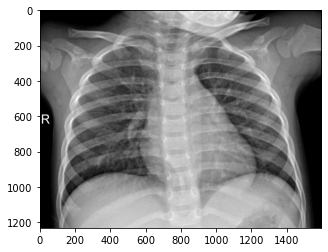

In [58]:
plt.imshow(img, cmap='gray')

Now we will create a series of transformations for the image using tools from the `torchvision.transforms` package. This includes:
- **Grayscale**: The X-ray data are single channel (i.e. grayscale) images. However, the pretrained model we wil work with was trained on RGB (i.e. three-channel) images. To make the inputs the appropriate shape, this transformation will copy the image to make it three channels.
- **RandomResizedCrop**: This will will take a crop of the original image (0.85-1x the original) and then resize it to a 256x256 square image.
- **RandomRotation**: Adds a small random amount of rotation as this doesn't effect the interpretation of the image. We don't want to add too much though.
- **RandomHorizontalFlip**: Randonly flips the image. A horizontal flip doesn't alter the prognosis, so we can include this to add additional variation. Vertical flips would not be suitable as we won't have upside down X-ray images.
- **CenterCrop**: We take a central crop as the main focus should be in the center of the image. It is resized to 224x224 pixels as this is the expected input size for the pretarined ResNet18 model.



In [59]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(size=256, scale=(0.85, 1.0)),
    transforms.RandomRotation(degrees=5, expand=True),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(size=224)

    ])

Torchvision doesn't accept NumPy arrays as input, so let's first convert the image back to a Pillow image type:

In [60]:
img = Image.fromarray(img)

Now pass it through the transformation twice and plot the results.

In [61]:
# torch transform returns a 3 x W x H image, we only show one color channel
augmented_image_1 = transform(img)
augmented_image_2 = transform(img)

Text(0.5, 1.0, 'Augmented image 2')

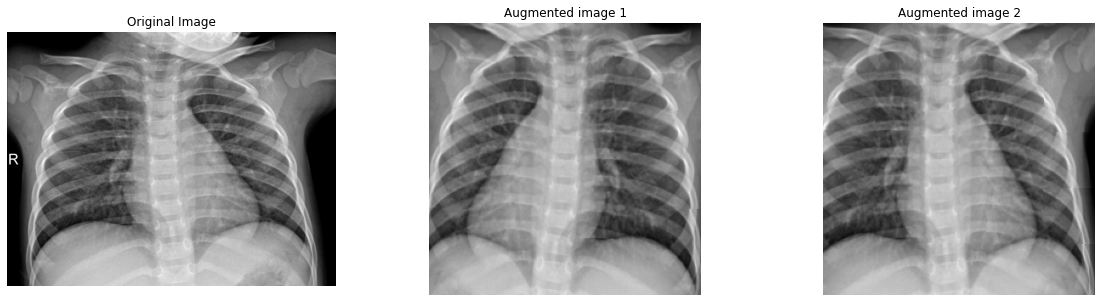

In [62]:

fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].imshow(img, cmap='gray')
axs[0].set_axis_off()
axs[0].set_title('Original Image')

axs[1].imshow(augmented_image_1, cmap='gray')
axs[1].set_axis_off()
axs[1].set_title('Augmented image 1')

axs[2].imshow(augmented_image_2, cmap='gray')
axs[2].set_axis_off()
axs[2].set_title('Augmented image 2')

So we can see that we now have two slightly different views of the input image which may help the model to generalize better to images that it has not seen before.

### Create Dataset and DataLoader
Here I'll create the DataLoader and check that the outputs look okay. The training transforms are the same as the last part, except that we also add two additional steps. The `ToTensor()` step will convert the data to PyTorch tensors and put them in the range of [0,1]. Then the `Normalize` method is used to normalize the data. Note that the mean and standard deviation values are the statistics from the ImageNet dataset, which we use since we the pretrained model was trained using that data.

In [63]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(size=256, scale=(0.85, 1.0)),
    transforms.RandomRotation(degrees=5, expand=True),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

But for the validation data, we only need to apply certain steps to make sure the image has three chanells and is the correct size. Here we don't apply any image augmentation steps such as horizontal flipping and rotation.

In [64]:
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

We can use the `ImageFolder` class from torchvision to generate a PyTorch dataset based oon a folder containing images. This will recognize the subdirectories and use the name of these as the labels.

In [65]:
train_dataset = ImageFolder(
    './chest_xray/train', 
    transform=train_transforms)

In [66]:
val_dataset = ImageFolder(
    './chest_xray/val', 
    transform=val_transforms)

In [67]:
len(train_dataset), len(val_dataset)

(5216, 320)

Now we use the Datasets to create a PyTorch DataLoader which we will iterate over during training. 

In [68]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True
)

In [69]:
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=True
)

### QC outputs from DataLoader

We can can get a batch of data from a DataLoader as shown below:

In [70]:
batch = next(iter(train_dataloader))

In [71]:
len(batch), batch[0].shape, batch[1].shape

(2, torch.Size([16, 3, 224, 224]), torch.Size([16]))

This contains two parts. the first element is a PyTorch tensor containing the image data. Note that we have 16 images (the batch size) and the images have dimensions of 3x224x224. PyTorch expects images to be ordered as CxHxW, so this is correct.

In [100]:
batch[0][0].shape

torch.Size([3, 224, 224])

The second part is the labels which have been converted to a PyTorch tensor. Here, 0 represents a normal X-ray while 1 is an image with pneumonia.

In [101]:
batch[1].data

tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

Lets plot a histogram of the image data to make sure that the values are in the expected range.

(array([  660.,  1266.,  3718.,  9164., 16684., 21737., 30026., 35936.,
        26636.,  4701.]),
 array([-1.6555357 , -1.3009276 , -0.9463196 , -0.5917116 , -0.2371035 ,
         0.11750454,  0.4721126 ,  0.82672065,  1.1813287 ,  1.5359367 ,
         1.8905448 ], dtype=float32),
 <BarContainer object of 10 artists>)

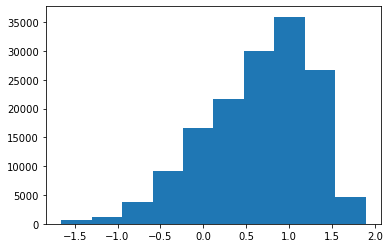

In [102]:
plt.hist(batch[0][0].numpy().flatten())

Although it is skewed, the values are not in an unexpected range, so this is probably okay. Remember we are normalizing with teh ImageNet statistics rather than those of the X-ray dataset, which may be one reason for this.

Finally, lets plots some outputs images from the DataLoader and the corresponding labels.

In [75]:
def plot_dataloader_imgs(dataloader, num_images):
    batch = next(iter(dataloader))
    imgs = batch[0][:num_images]
    labels = batch[1][:num_images]
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(15,5))
    for i in range(num_images):
        img = imgs[i].numpy()   
        img = np.transpose(img, (1,2,0))
        axs[i].imshow(img[:,:,0], cmap='gray')
        if labels[i].numpy() == 0:
            label = 'Normal'
        elif labels[i].numpy() == 1:
            label = 'Pneumonia'
        axs[i].set_title(label)


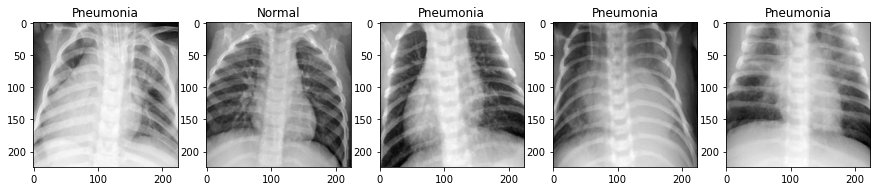

In [76]:
plot_dataloader_imgs(train_dataloader, 5)

## Model training


### Debugger profiling report
Before we run a hyperparameter search we should run a small test to make sure that we don't have any major issues. We can then fix these before running many training jobs. 

Useful resources:
- Example [notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_profiling/pt-resnet-profiling-single-gpu-single-node.ipynb) for creating debugging profile report for PyTorch job


#### Configure rules
Below the following rules are defined:
- **vanishing_gradients**: 


The **ProfilerReport** will run these rules and automatically generate a report which highlights issues and provides recommendations for improvement.

In [77]:
# Set up debugging and profiling rules and hooks
rules = [Rule.sagemaker(rule_configs.vanishing_gradient()),
         Rule.sagemaker(rule_configs.overfit()),
         Rule.sagemaker(rule_configs.overtraining()),
         Rule.sagemaker(rule_configs.poor_weight_initialization()),
         Rule.sagemaker(rule_configs.loss_not_decreasing()),
         ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
         ProfilerRule.sagemaker(rule_configs.ProfilerReport())]


#### Profiler configuration
Below we configure the profiler to capture system information (such as CPU and GPU usage) every 500 ms and capture detailed profiling information for 10 steps.

In [78]:

profiler_config = ProfilerConfig(system_monitor_interval_millis=500,
                                 framework_profile_params=FrameworkProfile(num_steps=10))


In [79]:

collection_configs=[
        CollectionConfig(name="weights"),
        # CollectionConfig(name="gradients"),
        # CollectionConfig(name="losses"),
        # CollectionConfig(name="biases")
    ]


In [ ]:
s3_output_dir = f's3://{S3_BUCKET_NAME}/udacity-aws-nd/course3/project/outputs/'

In [80]:

debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs,
    s3_output_path= s3_output_dir,
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)


#### Setup Estimator
Now we configure a `PyTorch` estimator for training a model.

A few things to note:
- **entry_point**: Points to to the script that will be run to train the model (in this case `train_model.py`).
- **source_dir**: If we want to include more than just a script to run training we can put them inside a dedicated directory. In this case we have a folder named `source_dir` which is in this repo. For instance, here we can include a `requirements.txt` file which includes any packages that are not installed in the AWS PyTorch image environment. In this case I want to track using Weights & Biases so I included the `wandb` package.
- **instance_type**: Here I am using the `ml.p2.xlarge` instance type as it is what I have available in my account. This uses an NVIDIA K80 GPU, which is not the best but will do for now. Note that by default you will not have access to this instance type, so you may need to contact AWS support to increase your allowance.
- **instance_count**: Ideally i would run on more than one instance, but I only have one available.
- **use_spot_instances**:  For the case of debugging, I'll use the normal instance since I want to be able to debug quickly. I'll use spot instances for hyperparameter tuning.

We pass all of the parameters to my script as a dictionary to the `hyperparameters` argument. This inlcludes argumnets for `debugging` and `profiler` which will run SageMaker debugging and profiling if true. Note that passing booleans (i.e. True, False) causes issues with SageMaker (that I don't fully understand), so we need to pass these as strings (e.g. 'true', 'false'). 

In [114]:
s3_model_dir = f's3://{S3_BUCKET_NAME}/udacity-aws-nd/course3/project/models/'

In [81]:
estimator = PyTorch(
    entry_point='train_model.py',
    source_dir='./source_dir',
    role=SAGEMAKER_ROLE_ARN,
    py_version='py3',
    framework_version='1.8',
    instance_type='ml.p2.xlarge',
    instance_count=1,
    use_spot_instances=False,
    max_run=3600,
    checkpoint_s3_uri=s3_model_dir,
    output_path=s3_output_dir,
    base_job_name='x-ray-pneumonia-debug-profile',
    hyperparameters={
        "epochs": 5, 
        "output_dir": s3_output_dir,
        "wandb_tracking": 'true', 
        "wandb_project_name": 'udacity-nd_aws-ml-engineer_project3_xray-classification',
        "early_stopping": 'true',
        "patience": 10,
        "lr": 0.001,
        "batch_size": 128,
        "debugging": 'true',
        "profiler": 'true'
        },
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
    )


#### Train model

In [115]:
training_path = f's3://{S3_BUCKET_NAME}/{S3_DATA_PREFIX}/train'
validation_path = f's3://{S3_BUCKET_NAME}/{S3_DATA_PREFIX}/val/'

In [83]:
estimator.fit(inputs={'train': training_path,'val': validation_path}, wait=True) 


2022-04-02 15:25:51 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-04-02 15:26:51 Starting - Preparing the instances for training......
2022-04-02 15:28:01 Downloading - Downloading input data.........
2022-04-02 15:29:32 Training - Downloading the training image........................
2022-04-02 15:34:04 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-02 15:34:07,939 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-02 15:34:07,964 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-02 15:34:07,975 sagemaker_pytorch_container.training INFO     Invoking user 

#### Plot a debugging output

In [84]:
session = boto3.session.Session()
region = session.region_name


In [85]:

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")


Training jobname: x-ray-pneumonia-debug-profile-2022-04-02-15-25-48-961
Region: us-east-1


In [86]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()


[2022-04-02 18:59:29.352 DESKTOP-T8O836C:10544 INFO s3_trial.py:42] Loading trial debug-output at path s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-15-25-48-961/debug-output
[2022-04-02 18:59:32.100 DESKTOP-T8O836C:10544 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-04-02 18:59:33.283 DESKTOP-T8O836C:10544 INFO trial.py:210] Loaded all steps


['BCEWithLogitsLoss_output_0',
 'ResNet_bn1.weight',
 'ResNet_conv1.weight',
 'ResNet_fc.0.weight',
 'ResNet_layer1.0.bn1.weight',
 'ResNet_layer1.0.bn2.weight',
 'ResNet_layer1.0.conv1.weight',
 'ResNet_layer1.0.conv2.weight',
 'ResNet_layer1.1.bn1.weight',
 'ResNet_layer1.1.bn2.weight',
 'ResNet_layer1.1.conv1.weight',
 'ResNet_layer1.1.conv2.weight',
 'ResNet_layer2.0.bn1.weight',
 'ResNet_layer2.0.bn2.weight',
 'ResNet_layer2.0.conv1.weight',
 'ResNet_layer2.0.conv2.weight',
 'ResNet_layer2.0.downsample.0.weight',
 'ResNet_layer2.0.downsample.1.weight',
 'ResNet_layer2.1.bn1.weight',
 'ResNet_layer2.1.bn2.weight',
 'ResNet_layer2.1.conv1.weight',
 'ResNet_layer2.1.conv2.weight',
 'ResNet_layer3.0.bn1.weight',
 'ResNet_layer3.0.bn2.weight',
 'ResNet_layer3.0.conv1.weight',
 'ResNet_layer3.0.conv2.weight',
 'ResNet_layer3.0.downsample.0.weight',
 'ResNet_layer3.0.downsample.1.weight',
 'ResNet_layer3.1.bn1.weight',
 'ResNet_layer3.1.bn2.weight',
 'ResNet_layer3.1.conv1.weight',
 'Res

In [87]:
len(trial.tensor('ResNet_layer1.0.conv1.weight').steps(mode=ModeKeys.TRAIN))

3

In [91]:
trial.tensor('ResNet_layer1.0.conv1.weight').values()[0].shape

(64, 64, 3, 3)

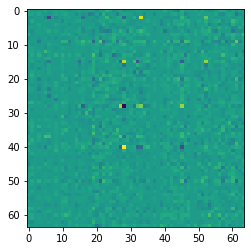

In [92]:
plt.imshow(trial.tensor('ResNet_layer1.0.conv1.weight').values()[0][:,:,0,0])

#### Display profiler output

In [98]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)


ProfilerConfig:{'S3OutputPath': 's3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-15-25-48-961/profiler-output


Profiler data from system is available
[2022-04-02 19:29:56.525 DESKTOP-T8O836C:10544 INFO metrics_reader_base.py:134] Getting 

### Download report

In [44]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output
2022-04-02 09:43:44     444829 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-04-02 09:43:43     305085 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-04-02 09:43:39        192 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-04-02 09:43:39     102168 udacity-aws-nd/course3/project/outputs/x-ray-pneumonia-debug-profile-2022-04-02-06-10-40-035/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-04-02 09:43:39       1966 udacity-aws-nd/course3/

This generates a report in a folder named `ProfilerReport/profiler-output`. Although we can import the report into the notebook, I find this causes issues with the notebook formatting, so it's better to just open either the `profiler-report.html` file in a web browser or the `profiler-report.ipynb` notebook that is also autogenerated. 

A snapshot from the report is provided below. There are no major issues. The rule that was triggered the most is the `GPUMemeoryIncrease` check. This was triggered 61 times out of 3578 data points. It might be better to use a different instance type with a better GPU/larger memory, such as the `ml.p3.xlarge` instances. However, this will take time to setup since I need to request AWS support to add this to my available resources and will also cost more money. For now I will stick with the `ml.p2.xlarge` instance.

One thing sthat we can do is increase the number of workers available for the PyTorch DataLoader. For this test it was left at the default (0, meaning one it uses the main process), but I have four CPUs available on this instance type so we can increase the number of workers.

<p align="center">
    <img src="./imgs/aws-report.png", width="800">
</p>
<p align="center">
    <em>Screenshot of SageMaker debugging report.</em>
</p>


If you really want to load the report into this notebook, then uncomment the cell below and run it. However it's much better to open the report directly from the `ProfilerReport` folder.

In [ ]:
# # get the autogenerated folder name of profiler report
# profiler_report_name = [
#     rule["RuleConfigurationName"]
#     for rule in estimator.latest_training_job.rule_job_summary()
#     if "Profiler" in rule["RuleConfigurationName"]
# ][0]
# IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Hyperparameter Tuning
Here we will for a small hyperparameter search to tune the learning rate and batch size for the final model.

**Note:** We won't run debugging during the hyperparameter tuning, so we can set the `debugging` and `profiler` parameters to 'false' (again, this needs to be passed as a string, not a boolean). I put this option in my `train_model.py` code so that I don't need to have two separate files for HPO and final training/debugging (since most of the code would ahve been identical).

#### Hyperparameter search space
We specify the hyperparameters we want to serach over in a dictionary like shown below. In this example, I will just search over the learning rate and batch size, but typically we may include more parameters. 

In [106]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
}


#### Defining and capturing metrics
The tuning job needs a metric to evaluate it's performance to enable it to decide what parameters to try next (the search uses Bayesian optimization by default). During training we need to print this information to the AWS logs and then tell the hyperparameter tuner how to retrieve this information using regex expressions. 

As you can see below, I'm using the validation F1 score as my evaluation metric. In the `train_model.py` code, the following line is included to log the validation loss and metrics:

```
logger.info(f'Val_epoch {epoch}: Val_loss={val_loss}, Val_f1={val_f1}; Val_accuracy={val_acc}; Patience={_patience}')
```

An example of what the output of this looks like in the AWS Cloudwatch logs is shown below.

<p align="center">
    <img src="./imgs/cloudwatch-training-log.png", width="800">
</p>
<p align="center">
    <em>Example training log in AWS CloudWatch with validation loss and metrics.</em>
</p>


In [107]:

objective_metric_name = "validation:f1"
objective_type = "Maximize"
metric_definitions=[
       {'Name': 'train:accuracy', 'Regex': 'Train_accuracy=(.*?);'},
       {'Name': 'validation:accuracy', 'Regex': 'Val_accuracy=(.*?);'},
       {'Name': 'train:f1', 'Regex': 'Train_f1=(.*?);'},
       {'Name': 'validation:f1', 'Regex': 'Val_f1=(.*?);'}
    ]

See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html) for more information about capturing metrics from AWS logs.

#### Configure PyTorch estimator
- **use_spot_instances**: Spot instances are much cheaper to run (typically around 70% less) so I prefer to use these. Note that you need to request spot instance allowance from AWS support for some reason (i.e. if you have allowance for `ml.p2.xlarge`) you still need to request separate access for spot instances.

In [108]:
# Create estimators for your HPs

estimator = PyTorch(
    entry_point='train_model.py',
    source_dir='./source_dir',
    role=SAGEMAKER_ROLE_ARN,
    py_version='py3',
    framework_version='1.8',
    instance_type='ml.p2.xlarge',
    max_run=3600,
    max_wait=7200,
    checkpoint_s3_uri=s3_model_dir,
    output_path=s3_output_dir,
    use_spot_instances=True,
    instance_count=1,
    hyperparameters={
        "epochs": 20, 
        "output_dir": s3_output_dir,
        "wandb_tracking": 'true', 
        "wandb_project_name": 'udacity-nd_aws-ml-engineer_project3_xray-classification',
        "early_stopping": 'true',
        "patience": 10,
        "num_workers": 4,
        "debugging": 'false',
        "profiler": 'false'}
    )

#### Configure hyperaparameter tuner

In [109]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=1,
    objective_type=objective_type,
    base_tuning_job_name='hpo-xray-pneumonia'
)

#### Run hyperparameter search

In [110]:
tuner.fit(inputs={'train': training_path,'val': validation_path}, wait=True) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Once the job starts, you will be able to see it under the Training > Hyperparameter tuning jobs tab in the AWS SageMaker console (see left tab). Each model is run as a separate Training job. 

If you need to stop the hyperparameter tuning job, you can use the AWS CLI (needs to be configured).

```
aws sagemaker stop-hyper-parameter-tuning-job --hyper-parameter-tuning-job-name <tuning_job_name>
```

#### View results in Weights and Biases
If you are tracking in W&B, you'll be able to view the outputs of teh search very easily.

#### Get best model and hyperparameters
Let's retrieve the best estimator and associated hyperparameters from the search.

In [111]:
best_estimator = tuner.best_estimator()



2022-04-02 23:53:39 Starting - Preparing the instances for training
2022-04-02 23:53:39 Downloading - Downloading input data
2022-04-02 23:53:39 Training - Training image download completed. Training in progress.
2022-04-02 23:53:39 Uploading - Uploading generated training model
2022-04-02 23:53:39 Completed - Training job completed


In [113]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"validation:f1"',
 'batch_size': '"64"',
 'debugging': '"false"',
 'early_stopping': '"true"',
 'epochs': '20',
 'lr': '0.09110604142226343',
 'num_workers': '4',
 'output_dir': '"s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/"',
 'patience': '10',
 'profiler': '"false"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-04-02-18-21-15-969"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://robsmith155-courses/pytorch-training-2022-04-02-18-21-15-969/source/sourcedir.tar.gz"',
 'wandb_project_name': '"udacity-nd_aws-ml-engineer_project3_xray-classification"',
 'wandb_tracking': '"true"'}

In [124]:
best_model_s3_path = best_estimator.hyperparameters()['output_dir'].replace('"', '') \
+ best_estimator.hyperparameters()['sagemaker_job_name'].replace('"', '') \
+ '/output/model.tar.gz'

In [125]:
print(best_model_s3_path)

s3://robsmith155-courses/udacity-aws-nd/course3/project/outputs/pytorch-training-2022-04-02-18-21-15-969/output/model.tar.gz


## Deploy best model
Here I will deploy the best model from the hyperparameter search.

- Note that need model_fn to be defined which tells it how to load model. Bettrer to do this in a separate `inference.py` file.
- remember to implement a model_fn as stated here so that your entry_point can be recognized as an inference script upon deployment.



### Create model endpoint

XXXX

In [144]:
pytorch_model = PyTorchModel(model_data=best_model_s3_path, 
                             role=SAGEMAKER_ROLE_ARN,
                             entry_point='inference.py',
                             framework_version='1.8',
                             py_version='py3')

In [145]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium") 

-----------!

#### Make prediction using endpoint

In [154]:
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False,
    pin_memory=False
)

In [155]:
# get some test images
val_dataiter = iter(val_dataloader)
images, labels = val_dataiter.next()

In [156]:
images.shape

torch.Size([4, 3, 224, 224])

In [158]:
outputs = predictor.predict(images.numpy())

In [159]:
outputs

array([[ 1.36341047],
       [-0.64456284],
       [-0.4366146 ],
       [-0.46713319]])

In [ ]:
def plot_dataloader_imgs(dataloader, num_images):
    batch = next(iter(dataloader))
    imgs = batch[0][:num_images]
    labels = batch[1][:num_images]
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(15,5))
    for i in range(num_images):
        img = imgs[i].numpy()   
        img = np.transpose(img, (1,2,0))
        axs[i].imshow(img[:,:,0], cmap='gray')
        if labels[i].numpy() == 0:
            label = 'Normal'
        elif labels[i].numpy() == 1:
            label = 'Pneumonia'
        axs[i].set_title(label)

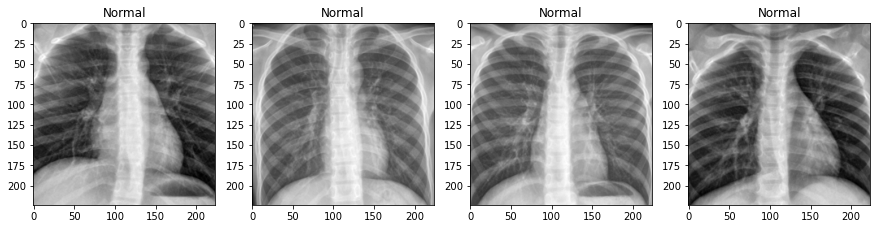

In [161]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
for i in range(len(images)):
    img = images[i].numpy()   
    img = np.transpose(img, (1,2,0))
    axs[i].imshow(img[:,:,0], cmap='gray')
    if labels[i].numpy() == 0:
        label = 'Normal'
    elif labels[i].numpy() == 1:
        label = 'Pneumonia'
    axs[i].set_title(label)

### Delete endpoint
Once finished it is very important to delete the endpoint, since you will be charged for the amount of time it is running (not the number of requests).

In [113]:
predictor.delete_endpoint()

## Areas for improvement
Here we focused on developing an end-to-end workflow that allows us to upload our data to S3, run hypeerparameter turning and deploy the final model to a SageMaker endpoint. There are many things that we could do to try to improve the performance of the model, including:

- **Oversampling minority class**: We saw before that we have an imbalanced training dataset, with around three pneumonia X-rays for every normal image. One way we can try to account for this is to sample the normal X-rays multiple times until we have the same number as the pneumonia samples.
- **Weighted loss function**: I forgot to add a weighting to the loss function. This would penalize mistakes with the minority class (in this case normal X-rays) more than those with pneumonia. However, we need to consider this carefully. Maybe it is better if a normal X-ray is mis-classified as pneumonia, so at least a radiologist can look at it in more detail. This might be preferable to misclassifying an X-ray with signs of pneumonia as being normal.
- **Extend fine-tuning**: Currently the model training only updates the weights in the very final layer of the model (fully connected layer). However, we can also fine-tune early layers (i.e. the convolutional part) of the model. 

# Additional notes

- Only need one output neuron as it's binary classification 
- Use `BCEWithLogitsLoss` so we don't need to apply activation function at the end of the network. This will apply Sigmoid for us.
- This loss expects the labels to be floats, not Long, so need to convert labels for loss. Outputs are probabilities
- Make sure the outputs and targets are the correct way around in the loss function.
- When it comes to making prediction for accuracy, if we want to use a threshold of 0.5 then this corresponds to any positive value in the raw logits accuracy = ((predictions > 0.0) == labels).float().mean()
- The fine-tuning applied here only trains the weighst of the last fully connected layer. We should also try unfreezing the ResNet18 model to let those weights be fine tuned. Typically would use smaller learning rate at beginning of network as things like edges don't need to change much.
- Script mode
- Managed training
- Local option in Estimator

- SM_MODEL_DIR should be left as the default. This point to a directory on the container. Once the training job is finished it will copy the file to our s3 bucket that we specify in SM_OUTPUT_DIR. SO we need to update SM_OUTPUT_DIR, but not SM_MODEL_DIR. https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html